In [1]:
# Import relevant libraries

import pandas as pd 
import numpy as np
import stropns
import matplotlib.pyplot as plt
from pylab import rcParams
import calendar
import warnings
from random import randint


In [2]:
# some characteristics about data

station = 'Punjabi Bagh'
year = 2018
month_entered = 10
pollutants = ['PM10', 'PM2.5', 'NH3', 'NO2', 'CO', 'SO2', 'Ozone']
pollutant = 'Ozone'
units = {'PM10':'ug/m3', 'PM2.5':'ug/m3', 'Ozone':'ug/m3', 'SO2':'ug/m3', 'CO':'mg/m3', 'NO2':'ug/m3', 'NH3':'ug/m3'}

In [3]:
# window size is 96 because it is the number of 15 minutes in a day, and for rolling mean and rolling
# standard de tviation calculations, window size of 1 day is chosen.
window = 96

# Functions to calculate rolling mean and rolling standard deviation

def rolmean(lst, window):
    st_indx = window-1
    rolling_mean_list = []
    for i in range(len(lst)):
        if i < st_indx:
            continue
        last_win = lst[i-window+1:i+1]
        rolling_mean_list.append(round(np.mean(last_win),2))
    return rolling_mean_list

def rolstd(lst, window):
    st_indx = window-1
    rolling_std_list = []
    for i in range(len(lst)):
        if i < st_indx:
            continue
        last_win = lst[i-window+1:i+1]
        rolling_std_list.append(round(np.std(last_win),2))
    return rolling_std_list

In [4]:
# manually read data from a csv file and store it into the variable 'data'

date = []
data = []

with open('punjabi_bagh_2018.csv', 'r') as hand:
    for line in hand:
        line = line.rstrip()
        line = line.split(';')
        index = pollutants.index(pollutant)+2
        
        if int(line[0].split('-')[1]) == month_entered:
            if line[index] == 'None' or line[index] == "" or line[index] == '0':
                continue

            val = line[index].replace(",", ".")
            data.append(float(val))
            date.append(line[0])
hand.close()

# Data Analysis

First we will analyze the data with some line graphs.

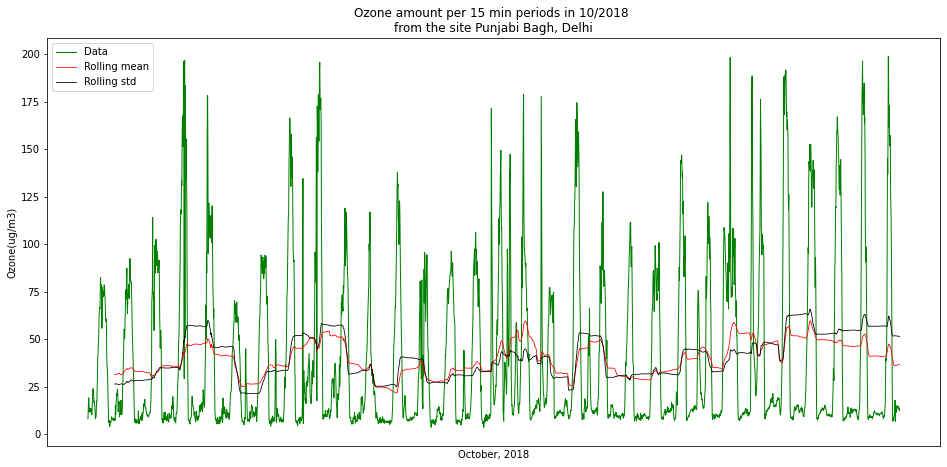

In [5]:
# plot the line graph of the data

if len(data) == 0:
    print('No Data')
else:
    rcParams['figure.figsize'] = 16, 7.5
    plt.figure()

    plt.plot(date, data, label='Data', color='green', linewidth = 1)
    
    plt.plot(date[window-1:], rolmean(data, window), label='Rolling mean', color='red', linewidth=0.80)
    plt.plot(date[window-1:], rolstd(data, window), label='Rolling std', color='black', linewidth=0.80)
    
    plt.xticks([])
    plt.ylabel('{}({})'.format(pollutant, units[pollutant]))
    plt.xlabel(calendar.month_name[month_entered] + ', ' + str(year))
    plt.title('{} amount per 15 min periods in {}/{} \nfrom the site {}, Delhi'.format(pollutant, month_entered, year, station))
    plt.legend(loc='best')
    plt.show()

## Trend and Seasonality
Looking at the line graph, we can see that there is no upward or downward trend in the data. Another thing we can say using this line graph is, there is some seasonality because the peaks have some period. Below using seasonal decomposition of the data, we will decide the amount of seasonality we have in this data.

Text(0.5, 0.91, ' from the station Punjabi Bagh, Delhi')

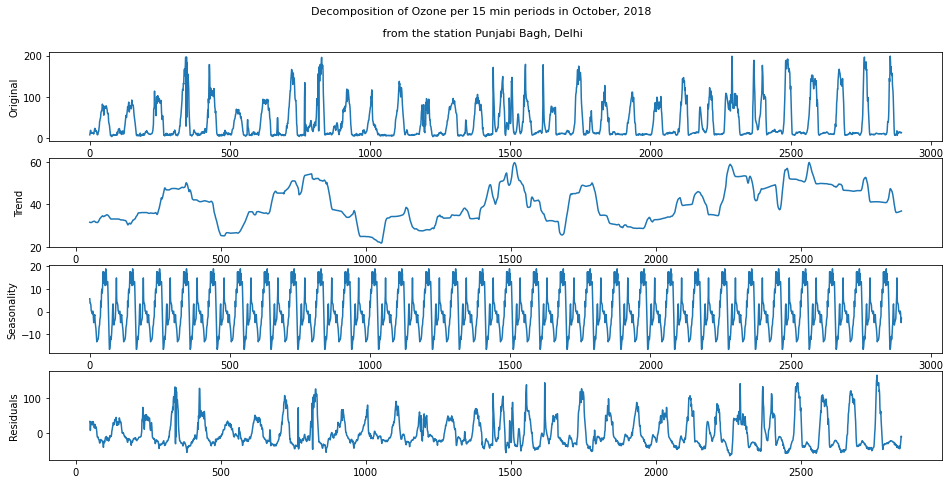

In [6]:
# Decompose the data into trend, seasonal and residual elements

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data, period=96)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


rcParams['figure.figsize'] = 16, 7.5
plt.figure()

plt.subplot(411)
plt.plot(data, label='Original')
plt.ylabel('Original')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.ylabel('Trend')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.ylabel('Seasonality')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.ylabel('Residuals')

#plt.title('Decomposition of {} per 15 min periods in {}, {} \n from the station {}, Delhi'.format(pollutant, calendar.month_name[month_entered], year, stropns.capitalize_first_letters(station)))

plt.figtext(.5, .95, 'Decomposition of ' + pollutant + ' per 15 min periods in ' + calendar.month_name[month_entered] + ', ' + str(year), fontsize=11, ha='center')
plt.figtext(.5, .91, ' from the station ' + stropns.capitalize_first_letters(station) + ', Delhi', fontsize=11,ha='center')

From above line graph named seasonality, same pattern occurs with an approximate perid of 100, an actually it is 96, which is the number of 15 minutes per day.

## White Noise Time Series
A time series is white noise if the variables are independent and identically distributed with a mean of zero. This means that all variables have the same variance and each value has a zero correlation with all other values in the series. If the time series is white noise, then a model cannot be created to make predictions.

To check if the time series is white noise, Ljung-Box Test is used.

Null Hypothesis : There is no autocorrelation between the signal and its lagged version
Alternate Hypothesis : There is significant autocorrelation between the signal and its lagged version

Reject the null hypothesis so the model is not white noise.

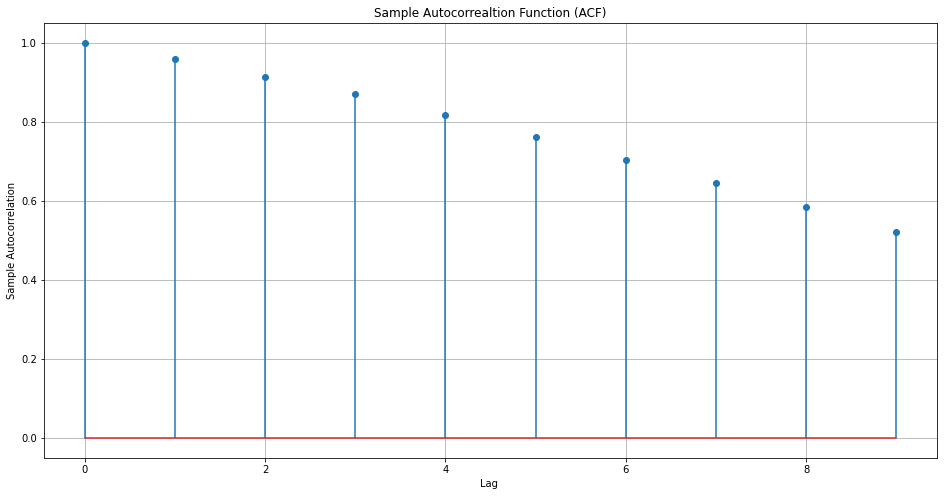

lag   p-value          Q    c-value   rejectH0
1       0.000   2663.383      2.706      True
2       0.000   5075.472      4.605      True
3       0.000   7267.983      6.251      True
4       0.000   9201.765      7.779      True
5       0.000  10887.555      9.236      True
6       0.000  12321.927     10.645      True
7       0.000  13528.789     12.017      True
8       0.000  14524.748     13.362      True
9       0.000  15316.793     14.684      True


In [7]:
# Below library is created by GitHub user bhattbhavesh91. (https://github.com/bhattbhavesh91/time_series_notebooks/tree/master/time_series_eda_and_white_noise_test)
from ljungbox import *

rcParams['figure.figsize'] = 16, 8
h = min((len(data)/5, 10)) # Number of lags
lags = range(h)
sa = np.zeros((h))

for k in range(len(lags)):
    sa[k] = sac(data, k)

plt.figure()
markerline, stemlines, baseline = plt.stem(lags, sa)
plt.grid()
plt.title('Sample Autocorrealtion Function (ACF)')
plt.ylabel('Sample Autocorrelation')
plt.xlabel('Lag ')
plt.show()


h, pV, Q, cV = lbqtest(data, range(1, h), alpha=0.1)
print ('lag   p-value          Q    c-value   rejectH0')
for i in range(len(h)):
    print ("%-2d %10.3f %10.3f %10.3f      %s" % (i+1, pV[i], Q[i], cV[i], str(h[i])))

We reject the null hypothesis in each lag, so the series is not white noise.

## Stationary Time Series
Forecasting with SARIMA requires data to be stationary. To check stationarity, two tests are used.

### Augmented Dickey-Fuller test for stationarity

If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). 
When the test statistic is greater than the critical value, 
we fail to reject the null hypothesis (which means the series is not stationary).

In [8]:
from statsmodels.tsa.stattools import adfuller

def adf_test(data):
    print('Resuls of the Dickey-Fuller Test: ')
    dftest = adfuller(data, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value

    print(dfoutput)

if data == []:
    print('No data')
else:
    adf_test(data)

Resuls of the Dickey-Fuller Test: 
Test Statistic                -1.202575e+01
p-value                        2.951782e-22
#Lags Used                     1.200000e+01
Number of Observations Used    2.883000e+03
Critical Value (1%)           -3.432620e+00
Critical Value (5%)           -2.862543e+00
Critical Value (10%)          -2.567304e+00
dtype: float64


### KPSS test for stationarity

If the test statistic is greater than the critical value, we reject the null hypothesis (series is not stationary). 
If the test statistic is less than the critical value, we fail to reject the null hypothesis (series is stationary).

In [9]:
from statsmodels.tsa.stattools import kpss

def kpss_test(data):
    print('Resuls of the KPSS Test: ')
    kpsstest = kpss(data, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print(kpss_output)

warnings.filterwarnings('ignore')

if data == []:
    print('No data')
else:
    kpss_test(data)

Resuls of the KPSS Test: 
Test Statistic            0.128319
p-value                   0.100000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


ADF test describes this data as stationary, KPSS test implies otherwise. This implies that this data has difference stationarity, and to make this time series staitonary, differencing should be applied.

Resuls of the Dickey-Fuller Test: 
Test Statistic                -1.036471e+01
p-value                        2.346715e-18
#Lags Used                     2.000000e+01
Number of Observations Used    2.779000e+03
Critical Value (1%)           -3.432705e+00
Critical Value (5%)           -2.862581e+00
Critical Value (10%)          -2.567324e+00
dtype: float64

Resuls of the KPSS Test: 
Test Statistic            0.03255
p-value                   0.10000
Lags Used                28.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


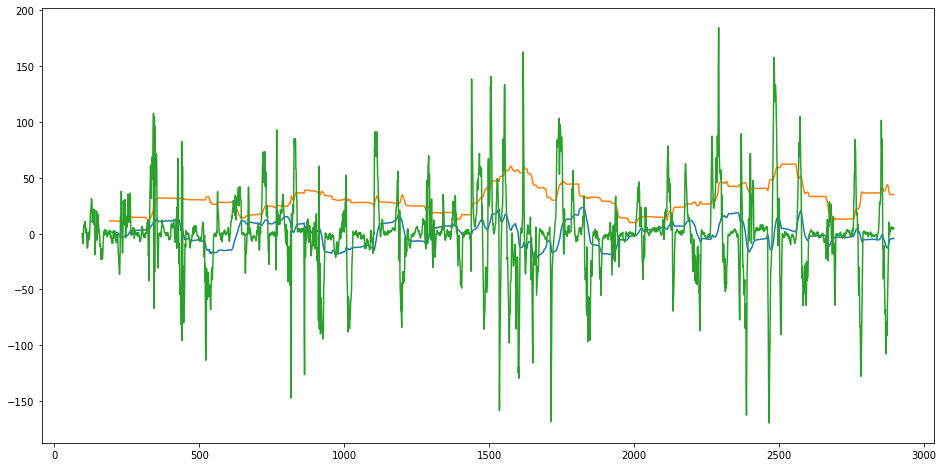

In [10]:
d = {"Pollution data":data}
df = pd.DataFrame(d)

df['Seasonal first diff'] = df['Pollution data'] - df['Pollution data'].shift(96)

adf_test(df['Seasonal first diff'].dropna())
print()
kpss_test(df['Seasonal first diff'].dropna())

plt.plot(df['Seasonal first diff'].rolling(window=96).mean())
plt.plot(df['Seasonal first diff'].rolling(window=96).std())
plt.plot(df['Seasonal first diff'])
plt.show()

With differencing order of 1, data is now stationary. This order of 1 is the differencing order of SARIMA model.

# Forecast
Now the data is stationary, foracasting can be made. Next we need to find the parameters of SARIMA model.

### Seasonal Element
Seasonality is decided to be 96, m=96.

### Integrated Element
Order of differencing, d, is 1.

### Autoregressive and Moving Average Element
In order to calculate the order of autoregressive and moving average models, partial autocorrelation and autocorrelation plots are used. When the value in the plots is above the 95% confidence interval (indicated with dashed red lines) at lag *k* and no bigger *k* satisfies this, then *k* is the order we seek.

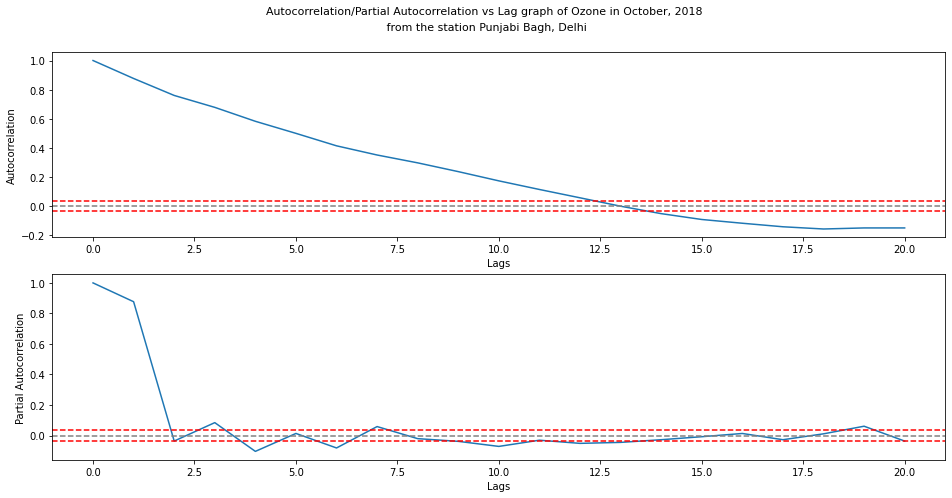

In [11]:
from statsmodels.tsa.stattools import acf, pacf

acf_data = acf(df['Seasonal first diff'].dropna(), nlags=20)
pacf_data = pacf(df['Seasonal first diff'].dropna(), nlags=20, method='ols')

# plot
rcParams['figure.figsize'] = 16, 7.5
plt.figure()

plt.figtext(.5, .95, 'Autocorrelation/Partial Autocorrelation vs Lag graph of ' + pollutant + ' in ' + calendar.month_name[month_entered] +  ', ' + str(year), fontsize=11, ha='center')
plt.figtext(.5, .92, ' from the station ' + stropns.capitalize_first_letters(station) + ', Delhi', fontsize=11, ha='center')

# plot acf
plt.subplot(211)
plt.plot(acf_data)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data)), linestyle='--', color='red')
plt.axhline(y=1.96/np.sqrt(len(data)), linestyle='--', color='red')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')

# plot pacf
plt.subplot(212)
plt.plot(pacf_data)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data)), linestyle='--', color='red')
plt.axhline(y=1.96/np.sqrt(len(data)), linestyle='--', color='red')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')

plt.show()

It can be seen from the plots that the orders for AR and MA model is p=2 and q=12. It is experimentally found that lower values of MA model is also giving the same results in a shorter time. That's why we pick q=1.

As a result, p=2, q=1, d=1, m=96.

Now we create the model with the appropriate parameters and do the forecast. To compare it with the actual data we use Root Mean Square Error (RMSE).

RMSE: 6.801815544808461


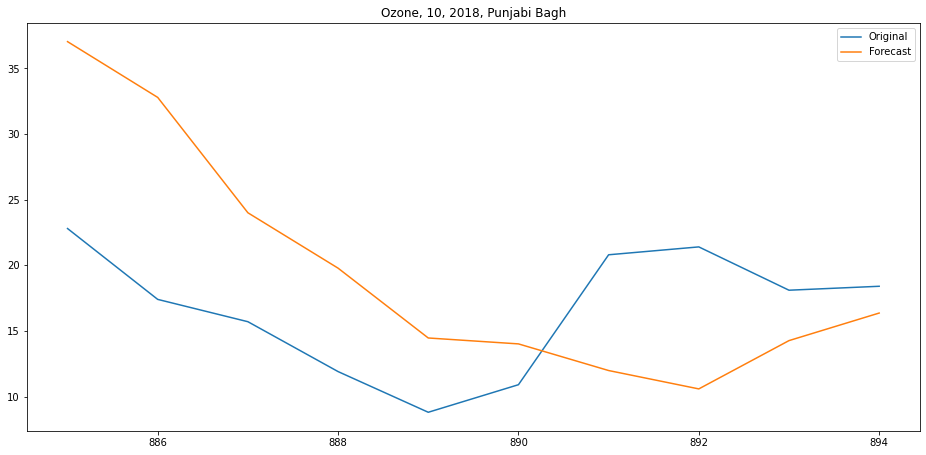

In [14]:
import statsmodels.api as sm 

# longer train size takes longer time to predict
train_size = 200
lead = 10

# randomly seelcted starting and ending indices on which we do forecast
st_index = randint(0, len(data)-train_size-1)
end_index = st_index + train_size

# create the model and do forecast
model=sm.tsa.statespace.SARIMAX(df.iloc[st_index:end_index, 0],order=(2,1,1),seasonal_order=(2,1,1,96), enforce_stationarity=False, enforce_invertibility=False)
results=model.fit(disp=0)
df['Forecast'] = round(results.predict(start=train_size-lead,end=train_size-1, dynamic=True),2)
df['Test data'] = df.iloc[end_index-lead:end_index, 0]

plt.plot(df['Test data'], label='Original')
plt.plot(df['Forecast'], label='Forecast')
plt.title(pollutant + ', ' + str(month_entered) + ', ' + str(year) + ', ' + station)
plt.legend()

print('RMSE: ' + str(np.sqrt(((results.fittedvalues - df['Test data']) ** 2).mean())))